In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.1.2+cu121
0.16.2+cu121


## 1 - Data Loading - CIFAR10

I've already downloaded the CIFAR-10 dataset into the current directory under: `CIFAR10/test` and `CIFAR10/train`. I'll set the `download` flag equal to `False`.

In [2]:
from torchvision.datasets import CIFAR10

train_data = CIFAR10(root="./CIFAR10/train/", train=True, download=False)
test_data = CIFAR10(root="./CIFAR10/test/", train=False, download=False)

### 1.1 - Data Inspection

It's always good practice to inspect the data before working on it to make sure it is what we expect.

In [3]:
print("Train data:", train_data.data.shape)
print("Test data:", test_data.data.shape)

print("\nTrain examples =", len(train_data))
print("Test examples =", len(test_data))

Train data: (50000, 32, 32, 3)
Test data: (10000, 32, 32, 3)

Train examples = 50000
Test examples = 10000


In [4]:
print("\nClasses:", train_data.classes)
print("Classes to Index:", train_data.class_to_idx)


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Classes to Index: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [5]:
data, label = train_data[0]
print(type(data))

<class 'PIL.Image.Image'>


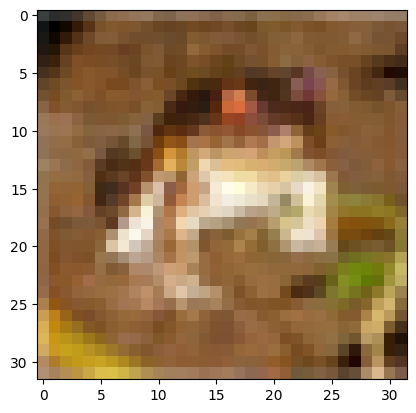

In [6]:
plt.imshow(data)

In [7]:
print(f"This is an image of a '{train_data.classes[label]}'")

This is an image of a 'frog'


### 1.2 - Data Transforms

Let's define the standard data transforms for the CIFAR-10 dataset below.

In [3]:
from torchvision import transforms

# train transforms contain data augmentation
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.2023, 0.1994, 0.2010))])

# test transforms don't contain data augmentation
test_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(
      (0.4914, 0.4822, 0.4465),
      (0.2023, 0.1994, 0.2010))])

In [4]:
train_data = CIFAR10(root="./CIFAR10/train/", train=True, download=False, transform=train_transforms)
test_data = CIFAR10(root="./CIFAR10/test/", train=False, download=False, transform=test_transforms)

In [10]:
data, label = train_data[0]
print(type(data))

<class 'torch.Tensor'>


In [11]:
data.shape

torch.Size([3, 32, 32])

Notice that the `type(data)` changed from `PIL.Image.Image` to `torch.Tensor`.

- `PIL` expects image dimensions for display as: (height, width, channels)
- `torch.Tensor` has dimensions: (channels, height, width)

In order to display the image using `PIL`, let's permute the dimensions so that the channels are the last at the last dimension.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


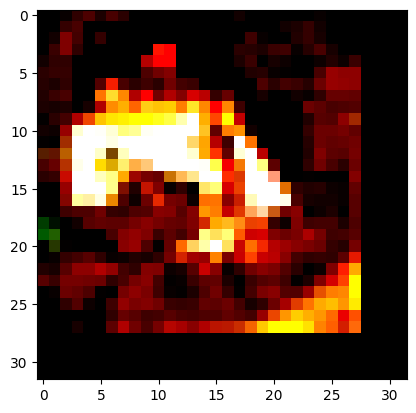

In [12]:
# plt.imshow(data)  # this will throw an error

plt.imshow(data.permute(1, 2, 0))

### 1.3 - Data Batching

Let's create appropriate `data loaders` for the above data for subsequent model training.

In [5]:
from torch.utils.data import DataLoader

In [6]:
trainloader = DataLoader(train_data, batch_size=16, shuffle=True)
testloader = DataLoader(test_data, batch_size=16, shuffle=False)

## 2 - Model Design

Let's create a model based on the existing `vgg-16` architecture.

In [15]:
from torchvision.models import vgg16
from torchinfo import summary
import torch.nn as nn

In [17]:
vgg16 = vgg16(pretrained=True)

D:\github\machine-learning\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\github\machine-learning\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
print(vgg16.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [19]:
# replace the last linear layer of the VGG-16 network to adjust for 10 classes instead of 1000
vgg16.classifier[-1] = nn.Linear(4096, 10)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [21]:
model = vgg16.to(device=device)

`VGG-16` has been pretrained on the `ImageNet` dataset which contains images of shape: (3, 224, 224). However, the `CIFAR-10` images are of shape: (3, 32, 32).

In [22]:
# summary with the original input size of (3, 224, 224), chosen batch size of 16
summary(vgg16, input_size=(16, 3, 224, 224), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [16, 10]                  --
+ Sequential: 1-1                        [16, 512, 7, 7]           --
|    + Conv2d: 2-1                       [16, 64, 224, 224]        1,792
|    + ReLU: 2-2                         [16, 64, 224, 224]        --
|    + Conv2d: 2-3                       [16, 64, 224, 224]        36,928
|    + ReLU: 2-4                         [16, 64, 224, 224]        --
|    + MaxPool2d: 2-5                    [16, 64, 112, 112]        --
|    + Conv2d: 2-6                       [16, 128, 112, 112]       73,856
|    + ReLU: 2-7                         [16, 128, 112, 112]       --
|    + Conv2d: 2-8                       [16, 128, 112, 112]       147,584
|    + ReLU: 2-9                         [16, 128, 112, 112]       --
|    + MaxPool2d: 2-10                   [16, 128, 56, 56]         --
|    + Conv2d: 2-11                      [16, 256, 56, 56]         29

In [23]:
# summary with the CIFAR-10 input size of (3, 32, 32), chosen batch size of 16
summary(vgg16, input_size=(16, 3, 32, 32), row_settings=("depth", "ascii_only"))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [16, 10]                  --
+ Sequential: 1-1                        [16, 512, 1, 1]           --
|    + Conv2d: 2-1                       [16, 64, 32, 32]          1,792
|    + ReLU: 2-2                         [16, 64, 32, 32]          --
|    + Conv2d: 2-3                       [16, 64, 32, 32]          36,928
|    + ReLU: 2-4                         [16, 64, 32, 32]          --
|    + MaxPool2d: 2-5                    [16, 64, 16, 16]          --
|    + Conv2d: 2-6                       [16, 128, 16, 16]         73,856
|    + ReLU: 2-7                         [16, 128, 16, 16]         --
|    + Conv2d: 2-8                       [16, 128, 16, 16]         147,584
|    + ReLU: 2-9                         [16, 128, 16, 16]         --
|    + MaxPool2d: 2-10                   [16, 128, 8, 8]           --
|    + Conv2d: 2-11                      [16, 256, 8, 8]           29

**Question:** Why does the `vgg16.classifier` have the same output dimension in both cases when the input sizes are different?

**Answer:** The VGG-16 model's classifier maintains the same output dimensions for different input sizes because the model's architecture, specifically the fully connected layers leading to the output, expects a fixed-size vector. This is achieved through `adaptive pooling layers` denoted as [AdaptiveAvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html) that adjust the output of the convolutional layers to a consistent size, ensuring the fully connected layers receive inputs of the same dimension regardless of the initial image size.

<br>

**Question:** Is the first sequential layer identical in these two summaries?

**Answer:** Yes. The summaries demonstrate that despite the significant difference in input sizes (`3 x 224 x 224` for ImageNet and `3 x 32 x 32` for CIFAR-10), the architecture of VGG-16, starting from the initial convolutional layer, remains consistent. The model is able to adapt to these differing input sizes through its convolutional and pooling layers, which systematically reduce the spatial dimensions of the feature maps while preserving the depth (number of channels) up to the point of the adaptive pooling layer. This layer ensures that the output fed into the fully connected layers (the classifier) is of a fixed size, enabling the final classifier to maintain the same output dimensions (i.e., the number of classes) regardless of the input size.

<br>

**Question:** Why did we replace the last layer of the VGG-16 model?

**Answer:** The VGG-16 model, as originally designed, ends with a sequence of fully connected layers, where the final layer outputs predictions for 1000 classes (for the ImageNet dataset). By replacing the last layer (`classifier[-1]`) with a new `nn.Linear` layer that has 10 output features, we're adapting the model to output predictions for 10 classes instead of 1000. This is necessary when we want to use the pre-trained model for a different classification task with a different number of classes.

### 2.1 - Training Loop

In [8]:
from torch import optim

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [27]:
N_EPOCHS = 10
criterion.to(device)

for epoch in range(N_EPOCHS):
    epoch_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()
    
    # Print average loss for the epoch
    print(f"Epoch {epoch + 1}/{N_EPOCHS}, Loss: {epoch_loss / len(trainloader)}")

Epoch 1/10, Loss: 0.8063409635770321
Epoch 2/10, Loss: 0.5132027559965849
Epoch 3/10, Loss: 0.4179956641530991
Epoch 4/10, Loss: 0.35753010960787535
Epoch 5/10, Loss: 0.312806459659636
Epoch 6/10, Loss: 0.27655756955266
Epoch 7/10, Loss: 0.2515454013987631
Epoch 8/10, Loss: 0.22800738169282675
Epoch 9/10, Loss: 0.21122454772955737
Epoch 10/10, Loss: 0.1904889690096304


In [23]:
# # Save the model state dictionary
# model_path = "models/vgg16_10epochs.pth"
# torch.save(model.state_dict(), model_path)
# print(f"Model state dictionary saved to {model_path}")

In [24]:
# Load the trained model dictionary
model.load_state_dict(torch.load("models/vgg16_10epochs.pth"))
model.to(device)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [25]:
# Disable gradient computation
with torch.no_grad():
    correct = 0
    total = 0
    
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass to get outputs
        outputs = model(inputs)
        
        # The class with the highest output is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

Accuracy of the model on the test images: 89.56%


**Question:** Compare the accuracy of VGG16 on CIFAR10 with the accuracy we obtained with LeNet5. Why is one better than another?

**Answer:** With 10 epochs, we previously achieved a test accuracy of <font color="red"><b>63.22%</b></font> with `LeNet5` and now <font color="blue"><b>89.56%</b></font> with `VGG16`.

- **Architectural Complexity:** VGG16 is deeper with 16 layers, including 13 convolutional layers, compared to LeNet-5's simpler architecture with just two convolutional layers. This allows VGG16 to learn more complex features.

- **Feature Representation:** The depth of VGG16 enables it to capture intricate details and patterns in images, leading to better performance on complex tasks like image recognition on CIFAR10.

- **Parameter Efficiency:** VGG16 uses multiple 3x3 convolutional filters, enhancing its ability to capture spatial hierarchies in images more effectively than LeNet-5.

- **Advanced Training Techniques:** VGG16 benefits from modern training and regularization techniques such as dropout, batch normalization, and data augmentation, helping it generalize better.

- **Model Capacity vs. Dataset Complexity:** VGG16's higher model capacity is more suited for the complexity of CIFAR10, a dataset with 32x32 color images across 10 classes, whereas LeNet-5 was designed for simpler, grayscale images.

<font color="red">In the following cells, I'll repeat the same process as above but for the following dataset:</font>

```python
targets = [1, 3, 5, 9]
indices = [i for i, label in enumerate(train_data.targets) if label in targets]
from torch.utils.data.dataset import Subset
train_subset = Subset(train_data, indices)
```

#### 2.1.1 - Creating Subsets for Training and Testing
First, create subsets of training and testing data that include only the desired classes.

In [9]:
from torch.utils.data import Subset

targets = [1, 3, 5, 9]
indices_train = [i for i, label in enumerate(train_data.targets) if label in targets]
indices_test = [i for i, label in enumerate(test_data.targets) if label in targets]

train_subset = Subset(train_data, indices_train)
test_subset = Subset(test_data, indices_test)

In [10]:
trainloader = DataLoader(train_subset, batch_size=16, shuffle=True)
testloader = DataLoader(test_subset, batch_size=16, shuffle=False)

#### 2.1.2 - Adjust Labels During Training
Create a mapping for the labels to ensure they match the output of the model. Since we're focusing on four classes, we'll need to adjust the labels so they correspond to the new output dimension of the model.

In [11]:
labmap = {x: i for i, x in enumerate(targets)}

In [12]:
labmap

{1: 0, 3: 1, 5: 2, 9: 3}

##### Trained Model's Accuracy

We trained the model above on 10 classes. Let's check it's accuracy on the 4-class subset. The expectation is that the accuracy will be lower because the model was trained on 10 classes and now we're testing it on 4 classes.

In [13]:
def evaluate_accuracy(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            
            # The class with the highest output is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            
            # Adjust labels to match the new class indices
            new_labels = torch.tensor([labmap[label.item()] for label in labels], device=device)
            total += labels.size(0)
            correct += (predicted == new_labels).sum().item()
            
    return 100 * correct / total

In [33]:
model.classifier[-1] = nn.Linear(4096, 4)  # Adjust for 4 classes
model = model.to(device)
model.eval()

accuracy_trained = evaluate_accuracy(model, testloader)
print(f'Accuracy of the trained VGG16 on the subset: {accuracy_trained:.2f}%')

Accuracy of the trained VGG16 on the subset: 35.60%


<center><font color="red">As expected, evaluating a model that's trained on 10 classes on a 4 class subset reduces the accuracy from 89% down to 35%.</font></center>

#### 2.1.3 - Modify VGG16 Model for 4-Class Output
Next, modify the VGG16 model's classifier to output four classes instead of the original number of classes.

In [15]:
from torchvision.models import vgg16
import torch.nn as nn

model = vgg16(pretrained=True)
model.classifier[-1] = nn.Linear(4096, 4)  # 4 output neurons
model = model.to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [17]:
N_EPOCHS = 10
criterion.to(device)

for epoch in range(N_EPOCHS):
    epoch_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Remap labels to match the model's output classes
        remapped_labels = torch.tensor([labmap[label.item()] for label in labels], device=device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, remapped_labels)  # Use remapped labels here
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()
    
    # Print average loss for the epoch
    print(f"Epoch {epoch + 1}/{N_EPOCHS}, Loss: {epoch_loss / len(trainloader)}")

Epoch 1/10, Loss: 0.45504497165977953
Epoch 2/10, Loss: 0.30636019356250765
Epoch 3/10, Loss: 0.2592494462348521
Epoch 4/10, Loss: 0.22807511235773564
Epoch 5/10, Loss: 0.20458394996710122
Epoch 6/10, Loss: 0.1835371262997389
Epoch 7/10, Loss: 0.1692303007695824
Epoch 8/10, Loss: 0.15443577448222787
Epoch 9/10, Loss: 0.14019874628782272
Epoch 10/10, Loss: 0.1258624763947446


In [18]:
accuracy_trained = evaluate_accuracy(model, testloader)
print(f'Accuracy of the trained VGG16 on the subset: {accuracy_trained:.2f}%')

Accuracy of the trained VGG16 on the subset: 91.85%


<center><font color="red">Now that we've the model trained on the subset of just 4 classes, the model's accuracy is higher as expected: <b>91.85%</b></font></center>

In [19]:
# Save the model state dictionary
model_path = "models/vgg16_subset_10epochs.pth"
torch.save(model.state_dict(), model_path)
print(f"Model state dictionary saved to {model_path}")

Model state dictionary saved to models/vgg16_subset_10epochs.pth


## 3 - Contrastive Learning

<hr>

**Contrastive learning** is a technique used in machine learning to learn effective representations by contrasting positive pairs (similar) against negative pairs (dissimilar). This approach is particularly beneficial in semi-supervised learning scenarios where labeled data is scarce. The challenge lies in efficiently generating these pairs and providing them in a format that is compatible with various types of image datasets, which may differ in image dimensions and channels (color vs. grayscale).

In [2]:
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset, random_split

# Define transforms
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load datasets
train_data = CIFAR10(root="./CIFAR10/train/", train=True, download=False, transform=train_transforms)
test_data = CIFAR10(root="./CIFAR10/test/", train=False, download=False, transform=train_transforms)

### Creating Positive and Negative Pairs
Implement a custom dataset that internally handles the creation of positive and negative pairs. This dataset will take another dataset (like CIFAR10) as input and generate pairs on-the-fly.

<font color="red">I've implemented the ContrastiveDataset below as opposed to the **Cifar10_Cont_Dataset** discussed in lecture. Why?</font>

- **Direct Tensor Operations:**
    - ContrastiveDataset: Operates directly on PyTorch tensors, avoiding DataFrame overhead.
    - Cifar10_Cont_Dataset: May involve conversion to/from DataFrames and manual reshaping.


- **Pair Generation:**
    - ContrastiveDataset: Generates positive/negative pairs on-the-fly, enhancing memory efficiency.
    - Cifar10_Cont_Dataset: Potentially pre-computes pairs, which can be memory-intensive.


- **Preprocessing Requirements:**
    - ContrastiveDataset: Requires minimal external preprocessing; utilizes transforms within PyTorch.
    - Cifar10_Cont_Dataset: May require external preprocessing steps like flattening and standardization.


- **Transform Flexibility:**
    - ContrastiveDataset: Easily integrates with PyTorch’s transform pipeline for data augmentation.
    - Cifar10_Cont_Dataset: Might need custom preprocessing or reshaping steps outside of PyTorch's ecosystem.


- **Memory Efficiency:**
    - ContrastiveDataset: More memory-efficient due to dynamic pair generation.
    - Cifar10_Cont_Dataset: Less memory-efficient if storing all possible pairs or heavily preprocessed data.


- **Computational Overhead:**
    - ContrastiveDataset: Reduces computational overhead by generating pairs during data retrieval.
    - Cifar10_Cont_Dataset: May incur additional computational overhead due to preprocessing and data manipulation.


- **Specificity for Contrastive Learning:**
    - ContrastiveDataset: Specifically designed for contrastive learning with integrated positive/negative logic.
    - Cifar10_Cont_Dataset: More general-purpose, adaptable to various tasks with modifications.


- **Use Case Suitability:**
    - ContrastiveDataset: Ideal for contrastive learning tasks requiring efficient pair generation.
    - Cifar10_Cont_Dataset: Suitable for a broader range of tasks but may require more customization for efficiency.

In [36]:
import random

class ContrastiveDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.labels = dataset.targets if hasattr(dataset, 'targets') else [label for _, label in dataset]
        self.label_to_indices = {label: torch.where(torch.tensor(self.labels) == label)[0]
                                 for label in set(self.labels)}

    def __getitem__(self, index):
        img1, label1 = self.dataset[index]

        # Decide whether we want a positive or negative example
        should_get_same_class = random.randint(0, 1) == 0
        if should_get_same_class:
            img2_index = index
            while img2_index == index:  # Make sure it's not the same image
                img2_index = random.choice(self.label_to_indices[label1].tolist())
            # For a positive pair, img2 has the same label
            same_class = 1.0
        else:
            # Choose a different label
            different_label = random.choice(list(set(self.labels) - {label1}))
            img2_index = random.choice(self.label_to_indices[different_label].tolist())
            # For a negative pair, img2 has a different label
            same_class = 0.0
        img2, _ = self.dataset[img2_index]
        return img1, img2, torch.tensor([same_class], dtype=torch.float32)


    def __len__(self):
        return len(self.dataset)

#### Usage with DataLoader
We can now use this `ContrastiveDataset` with a `DataLoader` to iterate through our dataset in batches.

In [37]:
# Wrap the CIFAR10 dataset
train_contrastive_dataset = ContrastiveDataset(train_data)

# Create a DataLoader
train_loader = DataLoader(train_contrastive_dataset, batch_size=64, shuffle=True)

### 3.1 - Define a Model Architecture for Contrastive Learning

Let's start with a simple `Siamese` network architecture that uses a shared backbone to process both images of a pair. For simplicity, we'll use a pre-trained `ResNet` model as the backbone.

In [38]:
import torch
import torch.nn as nn
import torchvision.models as models

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # Load a pre-trained ResNet and remove the final fully connected layer
        self.backbone = models.resnet18(pretrained=True)
        
        # Store the number of input features to the final fully connected layer
        fc_in_features = self.backbone.fc.in_features
        
        # Replace the last FC layer with an Identity, since we'll add our own layer later
        self.backbone.fc = nn.Identity()
        
        # Add a new fully connected layer for embedding
        self.fc = nn.Linear(fc_in_features, 256)

    def forward(self, x1, x2):
        # Forward pass for each image through the backbone
        out1 = self.backbone(x1)
        out2 = self.backbone(x2)
        
        # Pass through the new fully connected layer
        out1 = self.fc(out1)
        out2 = self.fc(out2)
        
        return out1, out2

### 3.2 - Implement a Contrastive Loss Function

For simplicity, let's use a basic contrastive loss function.

In [27]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Calculate Euclidean distance between outputs
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        
        # Contrastive loss
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

### 3.3 - Training Loop
Here, we've `train_loader` as our DataLoader.

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [40]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for img1, img2, label in train_loader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        
        optimizer.zero_grad()
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.6715
Epoch [2/10], Loss: 0.2937
Epoch [3/10], Loss: 0.2992
Epoch [4/10], Loss: 0.3293
Epoch [5/10], Loss: 0.2405
Epoch [6/10], Loss: 0.2236
Epoch [7/10], Loss: 1.8358
Epoch [8/10], Loss: 0.2854
Epoch [9/10], Loss: 0.2494
Epoch [10/10], Loss: 0.3100


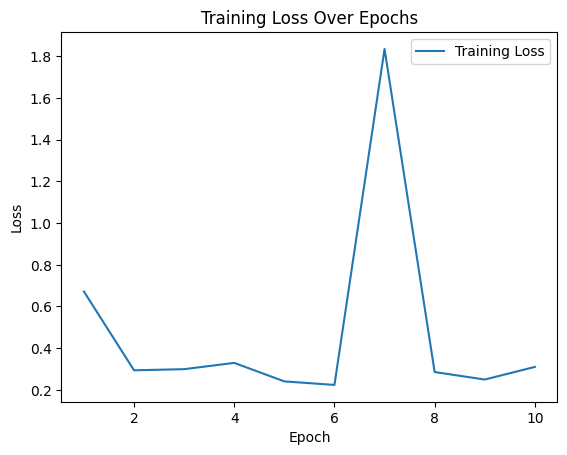

In [41]:
losses = [0.6715, 0.2937, 0.2992, 0.3293, 0.2405, 0.2236, 1.8358, 0.2854, 0.2494, 0.3100]
epochs = range(1, 11)

plt.plot(epochs, losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

### 3.4 - Extracting Embeddings
To extract embeddings, forward data through the model and collect the outputs.

In [44]:
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

In [45]:
model.eval()
embeddings = []
labels = []

with torch.no_grad():
    for img1, img2, label in train_loader:
        img1 = img1.to(device)
        # Forward pass to get embeddings. Only use img1 for simplicity.
        emb1, _ = model(img1, img1)  # We pass img1 as both inputs to get embeddings
        embeddings.append(emb1.cpu().numpy())  # Assuming we want to work with NumPy arrays
        labels.append(label.cpu().numpy())

# Optionally, concatenate all batched embeddings and labels into single NumPy arrays
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

In [49]:
labels_squeezed = labels.squeeze()
labels_series = pd.Series(labels_squeezed)

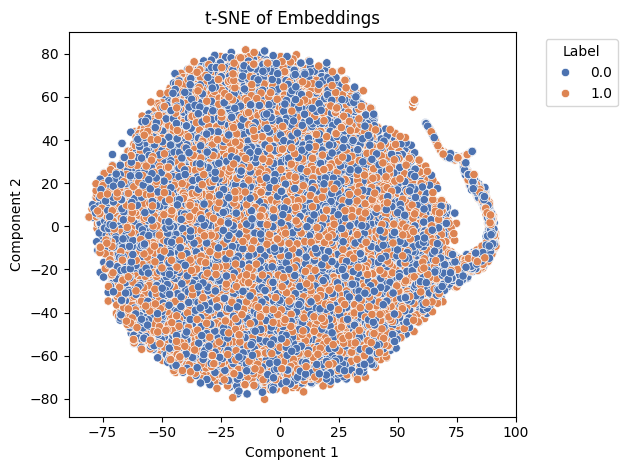

In [50]:
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=labels.squeeze(), palette="deep")
plt.title('t-SNE of Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()